In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm, tqdm_gui, tqdm_notebook
import networkx as nx

In [8]:
from nmp.node import Node
from nmp.edge import Edge
from nmp.message_passer import MessagePasser
from nmp.state_updator import StateUpdater

In [9]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output

process = psutil.Process(os.getpid())

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Tools

In [4]:
def get_lablesx(graphx):
    lablesx = dict()
    for node_id, node in graphx.nodes(data=True):
        lablesx[node_id] = int(node['signal'] >= 1)
    return lablesx


def get_central_node(lablesx):
    """
    return id of random node
    """
    lablesx_np = np.array(list(lablesx.values()))
    possible_labels=np.unique()
    return list(lablesx.keys())[np.random.choice(np.where(lablesx_np == np.random.choice(possible_labels))[0])]


def unique_neighbours_of_k_order(graphx: nx.DiGraph, node: int, order: int):
    neighbours = set([node])
    neighbours_layers_sets = list([neighbours])
    for k in range(order):
        neighbours = set((neighbour 
                          for node in neighbours 
                          for neighbour in (list(graphx.successors(node)) + list(graphx.predecessors(node))) ))
        neighbours_layers_sets.append(neighbours)
    
    neighbours = {}
    cumulative = set()
    k = 0
    for layer in neighbours_layers_sets:
        for node in (layer - cumulative):
            neighbours[node] = k
        cumulative = cumulative.union(layer)
        
        k += 1
    return neighbours


def get_subgraph_from_point(graphx: nx.Graph, central_node: int, 
                                 node_shape: int, edge_shape: int, 
                                 message_passers: dict, state_updater: StateUpdater,
                                 order: int = 2):
    k_order_neighbours = unique_neighbours_of_k_order(graphx, central_node, order)    
    subgraphx = graphx.subgraph(list(k_order_neighbours.keys()))

    # add torch nodes to subgraph attributes
    for node_id, node in subgraphx.nodes(data=True):
        node_torch = Node(
            name=str(node_id),
            data=np.array(
                [
                    node['features']['TX'],
                    node['features']['TY'],
                    (node['features']['chi2'] - 1.5) / 1.5
                ] + (node_shape - 3) * [0.]
            )
        )
        node_torch.set_state_updater(state_updater=state_updater)
        node['node_torch'] = node_torch
        node['order'] = k_order_neighbours[node_id]
        
        
    # add troch edges to subgraph attributes
    for node_u_idx, node_v_idx, edge_uv in subgraphx.edges(data=True):
        node_u_torch = subgraphx.node[node_u_idx]['node_torch']
        node_v_torch = subgraphx.node[node_v_idx]['node_torch']

        # create edge that connects node_u node_v
        edge_uv_torch = Edge(
            name=node_u_torch.name + node_v_torch.name, 
            data=np.array(
                [
                    edge_uv['features']['dsx'],
                    edge_uv['features']['dsy'],
                    edge_uv['features']['dsz'],
                    edge_uv['features']['dsxProjLeft'],
                    edge_uv['features']['dsyProjLeft'],
                    edge_uv['features']['dsxProjRight'],
                    edge_uv['features']['dsyProjRight'],
                    (edge_uv['features']['r'] - 200) / 200
                    
                ] + (edge_shape - 8) * [0.]
            )
        )
        edge_uv['edge_torch'] = edge_uv_torch
        
        edge_uv['message_passers'] = message_passers

    return subgraphx


def run_message_passing(subgraphx: nx.Graph, step: int):
    # passing messages
    for i, j, edge in subgraphx.edges(data=True):
        edge['message_passers'][step].pass_message(
            subgraphx.node[j]['node_torch'], 
            subgraphx.node[i]['node_torch'], 
            edge['edge_torch'])
              
    # updating nodes
    for i, node in subgraphx.nodes(data=True):
        node['node_torch'].update()
    
    return True


def make_predictions(subgraphx: nx.Graph, readout: 'Readout', order: int):
    """
    readout: Readout
    """
    nodes_predictions = []
    true_labels = []
    # make nodes predictions
    for node_id, node in subgraphx.nodes(data=True):
        if node['order'] <= order:
            nodes_predictions.append(readout.predict(node['node_torch'])[0])
            true_labels.append(int(node['signal'] >= 1))
    return nodes_predictions, true_labels

## Load dataset

In [ ]:
%%time
graphx_list_train = []
for k in np.arange(0, 1):
    with open('./data/brick_{}.pkl'.format(k), 'rb') as f:
        graphx = pickle.load(f)
    graphx_list_train.append(graphx)
lablesx_list_train = []
for graphx in graphx_list_train:
    lablesx_list_train.append(get_lablesx(graphx=graphx))


    
graphx_list_val = []
for k in np.arange(1, 2):
    with open('./data/brick_{}.pkl'.format(k), 'rb') as f:
        graphx = pickle.load(f)
    graphx_list_val.append(graphx)
    
lablesx_list_val = []
for graphx in graphx_list_val:
    lablesx_list_val.append(get_lablesx(graphx=graphx))

# Setup NNs for message passings, readouts and everything else

In [5]:
class MessagePasserNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32) # 32 / 64
        self.dropout_1 = nn.Dropout(p=0.1)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(64, 32)
        self.nonlinear_2 = nn.LeakyReLU()
        self.output = nn.Linear(32, output)

    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        # x = self.nonlinear_2(self.layer_2(x))
        return self.output(x)
    
class StateUpdaterNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.gru = nn.GRUCell(input, output)
    
    def forward(self, x, hidden_state):
        hidden_state = self.gru(x, hidden_state)
        return hidden_state

In [6]:
class Readout(object):
    def __init__(self, input: int, output: int, readout: nn.Module):
        """
        :param scope:
        """
        self.input = input
        self.output = output
        self.readout = readout(input, output)

    def predict(self, node: 'Node'):
        return self.readout(node.state[None, :])
    
    
class ReadoutNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 64)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(64, 32)
        self.dropout_2 = nn.Dropout(p=0.1)
        # self.nonlinear_2 = nn.LeakyReLU()
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        x = self.dropout_2(self.layer_2(x))
        # predicting raw output
        # if loss == logistic loss then raw output is logit or log-odds
        return self.output(x)


    
def make_loss(nodes_predictions, true_labels):
    labels = torch.tensor(true_labels, dtype=torch.int64)
    output_loss = F.nll_loss(torch.cat(nodes_predictions), labels)
    return output_loss

In [7]:
def r_at_fixed_p_loss(nodes_predictions, true_labels, lams: list, precisions: list, delta: float = 1.):
    """
    loss for maximising R at some fixed precision
    """
    assert len(lams) == len(precisions)
    nodes_predictions = np.array(nodes_predictions)
    true_labels = np.array(true_labels)
    L_total = []
    for precision, lam in zip(precisions, lams):
        if sum(nodes_predictions[true_labels >= 1.]):
            # hinge loss
            L_plus = torch.sum(torch.relu( delta - torch.cat(list(nodes_predictions[true_labels>=1])) ))
        if sum(nodes_predictions[true_labels == 0.]):
            # hinge loss
            # L_minus = torch.sum(torch.relu( delta + torch.cat(list(nodes_predictions[true_labels==0])) ))
        else:
            L_minus = 0.
        L_total.append(
            (1 + lam) * L_plus + L_minus * lam * precision / (1 - precision) - lam * float(sum(true_labels))
        )
    return sum(L_total)

In [ ]:
def r_at_fixed_p_loss(nodes_predictions, true_labels, lams: list, precisions: list, delta: float = 1.):
    """
    loss for maximising R at some fixed precision
    """
    assert len(lams) == len(precisions)
    nodes_predictions = np.array(nodes_predictions)
    true_labels = np.array(true_labels)
    L_total = []
    
    for precision, lam in zip(precisions, lams):
        if sum(nodes_predictions[true_labels >= 1.]):
            # hinge loss
            L_plus = torch.sum(torch.relu( delta - torch.cat(list(nodes_predictions[true_labels>=1])) ))
        if sum(nodes_predictions[true_labels == 0.]):
            # hinge loss
            L_minus = torch.sum(torch.relu( delta + torch.cat(list(nodes_predictions[true_labels==0])) ))
        else:
            L_minus = 0.
        L_total.append(
            (1 + lam) * L_plus + L_minus * lam * precision / (1 - precision) - lam * float(sum(true_labels))
        )
    return sum(L_total)

In [ ]:
from itertools import combinations
def loss_prauc(clusters, nodes_predictions, true_labels, lam, precision=0.8):
    predictions, _ = nodes_predictions
    loss = 0.
    N = len(clusters.keys())
    for label_1, label_2 in combinations(clusters.keys(), 2):
        # center between two clusters
        center = ((clusters[label_1]['mean'] + clusters[label_2]['mean']) / 2.).detach()
        
        if clusters[label_1]['mean'] < center:
            negative_label = label_1
            positive_label = label_2
        else:
            negative_label = label_2
            positive_label = label_1
        positive_predictions = predictions[true_labels==positive_label]
        negative_predictions = predictions[true_labels==negative_label]
        L_plus = torch.relu(1 + center - positive_predictions).sum()
        L_minus = torch.relu(1 - center + negative_predictions).sum()
        loss += (1 + lam) * L_plus + L_minus * lam * precision / (1 - precision) - lam * float(len(positive_predictions))
    return loss / (N * (N - 1))

## Initialization

## Grate cycle

In [8]:
def exctract_subgraph(graphx, lablesx, node_shape, edge_shape, 
                      readout, message_passers, state_updater, 
                      order=3, balanced=True):
    """
    """
    
    # get central node
    neighbourhood = 0
    while neighbourhood == 0:
        if balanced:
            central_node = get_central_node(lablesx=lablesx)
        else:
            
            central_node = np.random.choice(list(lablesx.keys()))
        neighbourhood = len(list(nx.neighbors(graphx, central_node)))
        
    # generate subgraph
    subgraphx = get_subgraph_from_point(
        graphx=graphx, central_node=central_node, 
        node_shape=node_shape, edge_shape=edge_shape,
        message_passer=message_passers, state_updater=state_updater, order=order
    )
    return subgraphx

In [9]:
def run_full_cycle_of_message_passing_and_predictions(subgraphx, lams, precisions, steps=1, delta=1.):
    # message passings + updates
    for i in range(steps):
        # message passing + updates with gru
        run_message_passing(subgraphx=subgraphx, step=i)

    # make predictions
    nodes_predictions, true_labels = make_predictions(subgraphx=subgraphx, readout=readout, order=steps)
    
    # loss
    # output_loss = make_loss(nodes_predictions, true_labels)
    output_loss = r_at_fixed_p_loss(nodes_predictions=nodes_predictions, true_labels=true_labels, 
                                    lams=lams, precisions=precisions, delta=delta)
    
    # reset graph
    for _, node in subgraphx.nodes(data=True):
        node['node_torch'].reset()
    
    return subgraphx, output_loss, nodes_predictions, true_labels

In [10]:
def batch_generator(graphx_list, lablesx_list, batch_size, 
                    node_shape, edge_shape, 
                    readout, message_passers, 
                    state_updater, order, balanced):
    subgraphx_list = []
    for j in tqdm(range(batch_size)):
        # choose random file
        file = np.random.choice(len(graphx_list))
        # run grate_eductator
        subgraphx = exctract_subgraph(
            graphx=graphx_list[file],
            lablesx=lablesx_list[file],
            node_shape=node_shape,
            edge_shape=edge_shape,
            readout=readout,
            message_passers=message_passers,
            state_updater=state_updater,
            order=order,
            balanced=True
        )
        subgraphx_list.append(subgraphx)
    return subgraphx_list

def train_step(subgraphx_list, optimizer_params, optimizers_lam, lams, precisions):
    ### params optimization
    optimizer_params.zero_grad()
    output_losses = []
    for subgraphx in tqdm(subgraphx_list):
        _, output_loss, _, _ = run_full_cycle_of_message_passing_and_predictions(subgraphx=subgraphx, lams=lams, precisions=precisions, delta=delta)
        output_losses.append(output_loss)
    global_loss = sum(output_losses) / len(output_losses)
    global_loss.backward()
    optimizer_params.step()
   
    ### lambda optimization
    for optimizer_lam in optimizers_lam:
        optimizer_lam.zero_grad()
    output_losses = []
    for subgraphx in tqdm(subgraphx_list):
        _, output_loss, _, _ = run_full_cycle_of_message_passing_and_predictions(subgraphx=subgraphx, lams=lams, 
                                              precisions=precisions, delta=delta)
        output_losses.append(output_loss)
    global_loss_lam = -sum(output_losses) / len(output_losses)
    global_loss_lam.backward()
    for optimizer_lam, lam in zip(optimizers_lam, lams):
        optimizer_lam.step()
        lam.data = torch.relu(lam.data)
        
def validation_step(subgraphx_list, optimizer_params, optimizers_lam, lams, precisions):
    output_losses = []
    nodes_predictions_all = []
    true_labels_all = []
    for subgraphx in tqdm(subgraphx_list):
        _, output_loss, nodes_predictions, true_labels = run_full_cycle_of_message_passing_and_predictions(subgraphx, lams=lams, 
                                                                        precisions=precisions, delta=delta)
        nodes_predictions_all.extend(nodes_predictions)
        true_labels_all.extend(true_labels)
        output_losses.append(output_loss)

    # mean loss
    global_loss = sum(output_losses) / len(output_losses)
    
    # different losses
    y_pred = [pred.detach().numpy()[0] for pred in nodes_predictions_all]
    y_true = true_labels_all
    
    return global_loss, np.array(y_true), np.array(y_pred)

In [11]:
print("Proccess is using {} GB. Free memory: {} GB".format(process.memory_info().rss / 2.**30, psutil.virtual_memory()[1] / 2.**30))

Proccess is using 0.18598556518554688 GB. Free memory: 164.73572158813477 GB


In [12]:
node_shape = 32 # tx, ty, chi2 + zeros
edge_shape = 32 # \delta_x \delta_y r
message_size = 32

message_passer = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN)
message_passers = {
    1: message_passer
}
state_updater = StateUpdater(input=message_size, output=node_shape, state_updater=StateUpdaterNN) 

readout = Readout(input=node_shape, output=1, readout=ReadoutNN)
params_trainable = (
    list(message_passer.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(state_updater.state_updater.parameters()))
print(len(params_trainable))

optimizer_params = optim.SGD(params_trainable, lr=1e-3, weight_decay=1e-9)

sum([p.numel() for p in params_trainable])

16


19873

In [13]:
# firstly define precisions
precisions = [0.99, 0.85]
prior = 0.5
weights=[]
for i in range(len(precisions)):
    try:
        weights.append(precisions[i] - precisions[i + 1])
    except:
        weights.append(precisions[i] - prior)
print(precisions)
print(weights)
# for each precision seperate lam
lams = []
optimizers_lam = []
for precision in precisions:
    lam = torch.tensor(0.01, dtype=torch.float32, requires_grad=True)
    optimizer_lam = optim.SGD([lam], lr=1e-3)
    lams.append(lam)
    optimizers_lam.append(optimizer_lam)

[0.99, 0.85]
[0.14, 0.35]


In [14]:
params_mpnn = dict(
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    order=2
)

In [15]:
log_loss_all = []
roc_auc_all = []
pr_auc_all = []
y_true_all = []
y_pred_all = []

In [16]:
optimizer_params.param_groups[0]['lr'] = 1e-3
for optimizer_lam in optimizers_lam:
    optimizer_lam.param_groups[0]['lr'] = 1e-3

[tensor(4.9628), tensor(2.4375)]
51. Proccess is using 53.62140655517578 GB. Free memory: 95.46507263183594 GB
class disbalance = positive / all = 0.21275176737361612


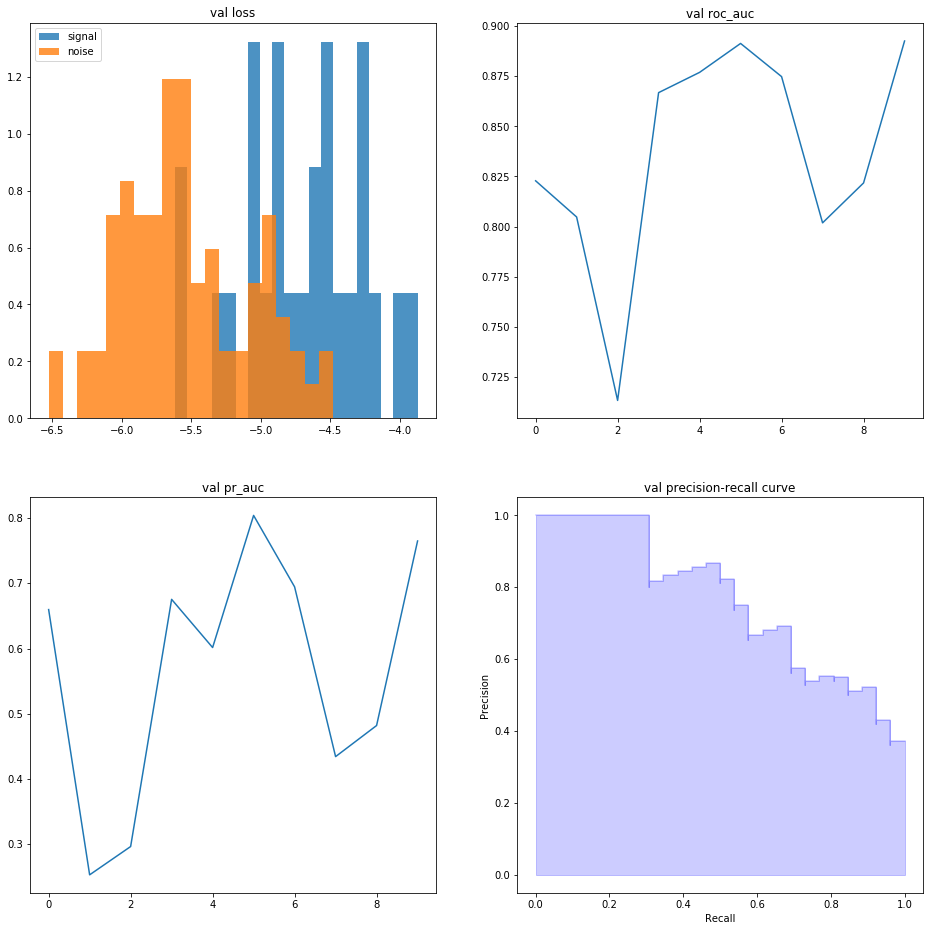

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

 35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]


KeyboardInterrupt: 

In [110]:
%%time
iters = 1000
delta = 1.
batch_size_train = 20
batch_size_val = 10

L_train = len(graphx_list_train)
L_val = len(graphx_list_val)

for i in tqdm(range(iters)):
    ### creating minibatch for train
    subgraphx_list_train = batch_generator(graphx_list=graphx_list_train, lablesx_list=lablesx_list_train, 
                                           batch_size=batch_size_train, 
                                           balanced=True, **params_mpnn)
    ### train step
    for j in range(1):
        train_step(subgraphx_list=subgraphx_list_train, 
                   optimizer_params=optimizer_params, 
                   optimizers_lam=optimizers_lam, lams=lams, precisions=precisions)
    
    
    
    ## creating minibatch for validation
    subgraphx_list_val = batch_generator(graphx_list=graphx_list_val, lablesx_list=lablesx_list_val,
                                         batch_size=batch_size_val, 
                                         balanced=True, **params_mpnn)
    ### validation
    global_loss, y_true, y_pred = validation_step(subgraphx_list=subgraphx_list_val, 
                                                  optimizer_params=optimizer_params, 
                                                  optimizers_lam=optimizers_lam, lams=lams, precisions=precisions)
    

    y_pred_all.extend(list(y_pred))
    y_true_all.extend(list(y_true))
    try:
        # different accumulated losses
        log_loss_all.append(log_loss(y_true=y_true, y_pred=y_pred))
        roc_auc_all.append(roc_auc_score(y_true=y_true, y_score=y_pred))
        pr_auc_all.append(average_precision_score(y_true=y_true, y_score=y_pred))    
    except:
        print('Ooops')
    # print stats and plot plots
    clear_output()
    print(lams)
    print("{}. Proccess is using {} GB. Free memory: {} GB".format(i, process.memory_info().rss / 2.**30, psutil.virtual_memory()[1] / 2.**30))
    print('class disbalance = positive / all = {}'.format(sum(y_true_all) / len(y_true_all)))
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(16, 16))
    axes[0][0].set_title('val loss')
    axes[0][0].hist(y_pred[y_true==1.], bins=20, normed=True, alpha=0.8, label='signal');
    axes[0][0].hist(y_pred[y_true==0.], bins=20, normed=True, alpha=0.8, label='noise');
    axes[0][0].legend()
    
    axes[0][1].set_title('val roc_auc')
    axes[0][1].plot(roc_auc_all[-10:]);
    
    axes[1][0].set_title('val pr_auc')
    axes[1][0].plot(pr_auc_all[-10:]);
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    axes[1][1].set_title('val precision-recall curve')
    axes[1][1].step(recall_curve, precision_curve, color='b', alpha=0.2,
             where='post')
    axes[1][1].fill_between(recall_curve, precision_curve, step='post', alpha=0.2,
                     color='b')
    axes[1][1].set_xlabel('Recall')
    axes[1][1].set_ylabel('Precision')
    
    plt.show()

In [88]:
np.unique(y_true, return_counts=True)

(array([ True]), array([131]))

In [ ]:
y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)

In [188]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(16, 16))
axes[0][0].set_title('val loss')
axes[0][0].hist(y_pred_all[y_true_all==1.], bins=20, normed=True, alpha=0.8, label='signal');
axes[0][0].hist(y_pred_all[y_true_all==0.], bins=20, normed=True, alpha=0.8, label='noise');

axes[0][1].set_title('val roc_auc')
axes[0][1].plot(roc_auc_all);

axes[1][0].set_title('val pr_auc')
axes[1][0].plot(pr_auc_all);

precision_curve, recall_curve, _ = precision_recall_curve(y_true_all, y_pred_all)
axes[1][1].set_title('val precision-recall curve')
axes[1][1].step(recall_curve, precision_curve, color='b', alpha=0.2,
         where='post')
axes[1][1].fill_between(recall_curve, precision_curve, step='post', alpha=0.2,
                 color='b')
axes[1][1].set_xlabel('Recall')
axes[1][1].set_ylabel('Precision')

plt.legend()
plt.show()

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.
